# Model

In [1]:
%load_ext autoreload
%autoreload 2

import os

In [2]:
path_list = os.getcwd().split('\\')
if path_list[-1] == 'src':
    print(os.getcwd())
else:
    os.chdir('..')
    print(os.getcwd())

F:\study\Hackatons\DashboardSber\src


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)

from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Загрузка данных

In [4]:
def fix_date_columns(df):
    new_columns = [df.columns[0]]
    for column in df.columns[1:]:
        date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(column) - 2).strftime('%Y-%m-%d')
        new_columns.append(date)

    df.columns = new_columns
    return df


df_acquiring = pd.read_excel(
    io='dataset/acquiring.xlsb',
    engine='pyxlsb',
    header=1,  # У файла есть заголовок-объединение
    # nrows=1000,
)
df_acquiring = fix_date_columns(df_acquiring)

# df_rko = pd.read_excel(
#     io='dataset/rko.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )
# df_rko = fix_date_columns(df_rko)

# df_economy_acquiring = pd.read_excel(
#     io='dataset/economy_acquiring.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_economy_general = pd.read_excel(
#     io='dataset/economy_general.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_general = pd.read_excel(
#     io='dataset/general.xlsb',
#     engine='pyxlsb',
#     header=0,  # У файла есть заголовок-объединение
# )
# df_general['Кластер'] = df_general['Кластер'].astype('category')

In [275]:
df_acquiring

,клиент,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,client_37877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
1,client_30115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
2,client_9554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,client_42590,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,client_14578,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48418,client_14953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48419,client_22472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
48420,client_41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48421,client_41941,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Расчёт двух формул

In [141]:
def customer_churn_share(df: pd.DataFrame, end_id_month: int) -> float:
    """Доля оттока клиентов."""
    have_clients = df.iloc[:, end_id_month - 1]
    have_clients = have_clients[have_clients == 1]

    not_have_clients = df.iloc[have_clients.index, end_id_month]
    not_have_clients = not_have_clients[not_have_clients == 0]

    value = not_have_clients.shape[0] / have_clients.shape[0] * 100
    return value


customer_churn_share(df_acquiring, 2)

3.225806451612903

In [125]:
def customer_survival_rate(df: pd.DataFrame, end_id_month: int) -> float:
    """Расчет процента выживаемости клиентов"""
    start_clients = df.iloc[:, end_id_month - 1]
    start_clients = start_clients[start_clients == 1]

    left_clients = df.iloc[start_clients.index, end_id_month]
    left_clients = left_clients[left_clients == 0]

    df_copy = df.copy()
    df_copy = df_copy.drop(start_clients.index, axis=0)
    new_clients = df_copy.iloc[:, end_id_month]
    new_clients = new_clients[new_clients == 1]

    end_clients = start_clients.shape[0] - left_clients.shape[0] + new_clients.shape[0]
    value = ((end_clients - new_clients.shape[0]) / start_clients.shape[0]) * 100
    return value


customer_survival_rate(df_acquiring, 2)

96.7741935483871

# Feature Engineering

In [128]:
series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values
level_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")].values

In [142]:
lst_customer_churn_share = [customer_churn_share(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_churn_share)

23

In [143]:
lst_customer_survival_rate = [customer_survival_rate(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_survival_rate)

23

In [162]:
df_cr_pr = pd.DataFrame(series_cols[1:], columns=["ds"])
df_cr_pr['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df_cr_pr.loc[:, "cr"] = lst_customer_churn_share
df_cr_pr.loc[:, "pr"] = lst_customer_survival_rate
df_cr_pr.head()

,ds,cr,pr
0,2021-11-30,3.225806,96.774194
1,2021-12-31,1.104972,98.895028
2,2022-01-31,1.104972,98.895028
3,2022-02-28,1.648352,98.351648
4,2022-03-31,1.111111,98.888889


# Модели

In [5]:
# Про prophet:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

In [ ]:
# Много моделей prophet с features:
# https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

In [278]:
TRAIN_END = -3

In [324]:
# timeseries = df_cr_pr.cr
timeseries = df_cr_pr.pr
# timeseries = df_acquiring[series_cols].sum().values

len(timeseries)

23

In [325]:
train_timeseries = timeseries[0:TRAIN_END]
eval_timeseries = timeseries[TRAIN_END::]
print(len(train_timeseries), len(eval_timeseries))

days = np.arange(1, len(train_timeseries) + len(eval_timeseries) + 1)
len(days)

20 3


23

In [326]:
df = pd.DataFrame(series_cols[len(series_cols) - len(days):], columns=["ds"])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.loc[:, "y"] = timeseries
df.tail()

,ds,y
18,2023-05-31,98.863821
19,2023-06-30,99.315947
20,2023-07-31,99.465104
21,2023-08-31,98.892330
22,2023-09-30,98.731054


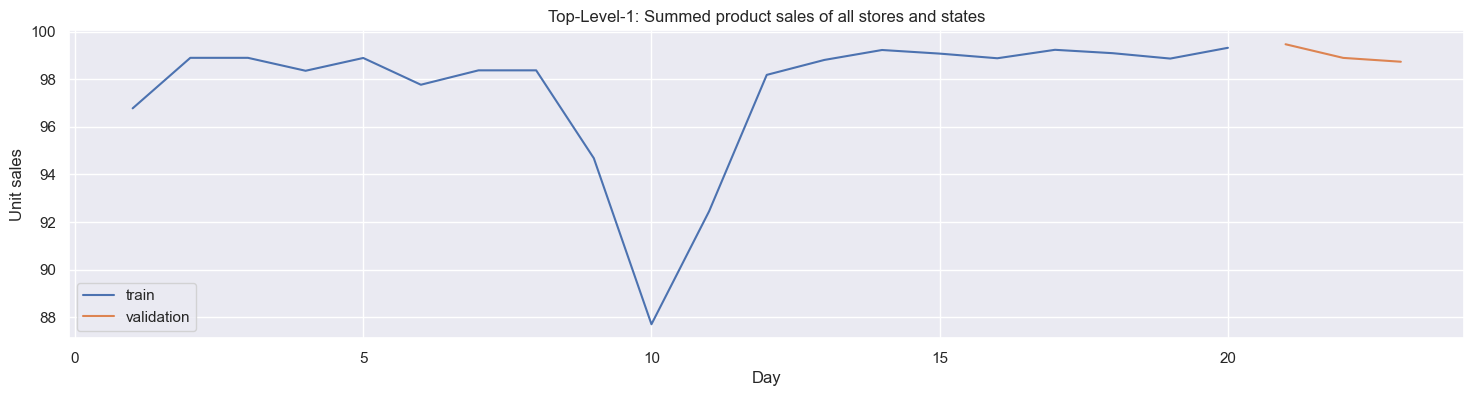

In [327]:
plt.figure(figsize=(18, 4))
plt.plot(days[0:TRAIN_END], train_timeseries, label="train")
plt.plot(days[TRAIN_END::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [328]:
train_df = df.iloc[0:TRAIN_END]
print(train_df.shape)

eval_df = df.iloc[TRAIN_END::]
print(eval_df.shape)

(20, 2)
(3, 2)


In [329]:
model = Prophet()
# model.add_regressor('tmp')
model.fit(train_df)

# future = model.make_future_dataframe(periods=abs(TRAIN_END), freq='M')
# future['tmp'] = [np.random.randint(-50, 50) for i in range(future.shape[0])]

pred = model.predict(eval_df)
pred.index = eval_df.index

pred.head()

19:38:01 - cmdstanpy - INFO - Chain [1] start processing
19:38:02 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
20,2023-07-31,100.072044,96.877809,103.145596,100.039251,100.101571,0.0,0.0,0.0,0.0,0.0,0.0,100.072044
21,2023-08-31,100.454775,97.530618,103.365945,100.354107,100.552697,0.0,0.0,0.0,0.0,0.0,0.0,100.454775
22,2023-09-30,100.825160,97.796675,103.750891,100.622871,101.029231,0.0,0.0,0.0,0.0,0.0,0.0,100.825160


In [330]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
pred[col_int].head()

,ds,yhat,yhat_lower,yhat_upper
20,2023-07-31,100.072044,96.877809,103.145596
21,2023-08-31,100.454775,97.530618,103.365945
22,2023-09-30,100.825160,97.796675,103.750891


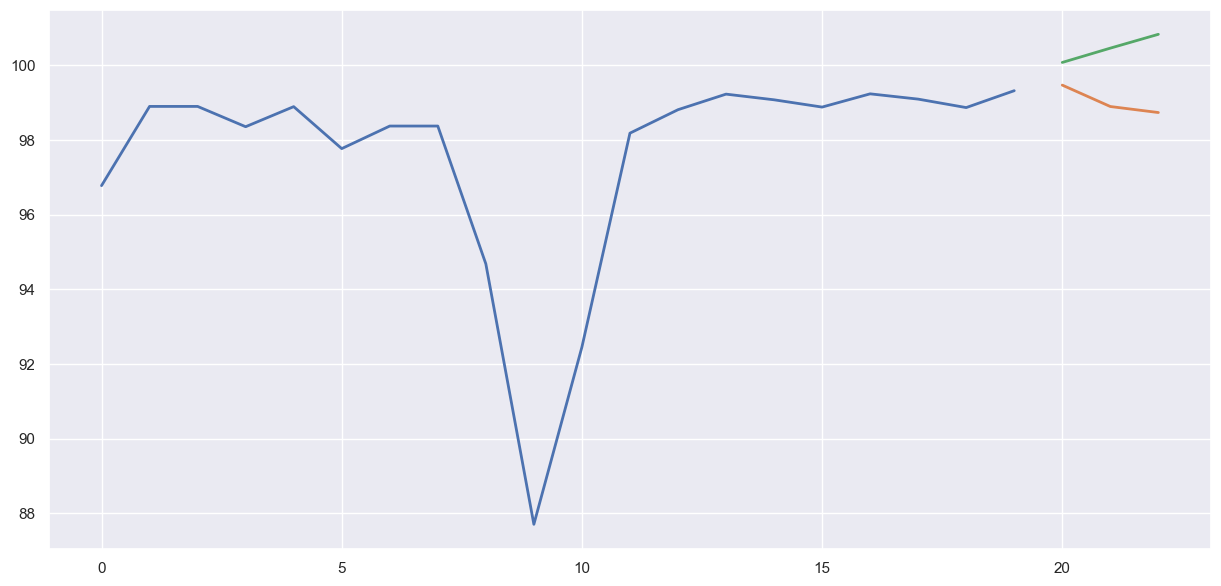

In [331]:
plt.figure(figsize=(15, 7))
plt.plot(pred.yhat, "g", label="prediction", linewidth=2.0)
plt.plot(train_df.y, label="actual", linewidth=2.0)
plt.plot(eval_df.y, label="actual", linewidth=2.0);

F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


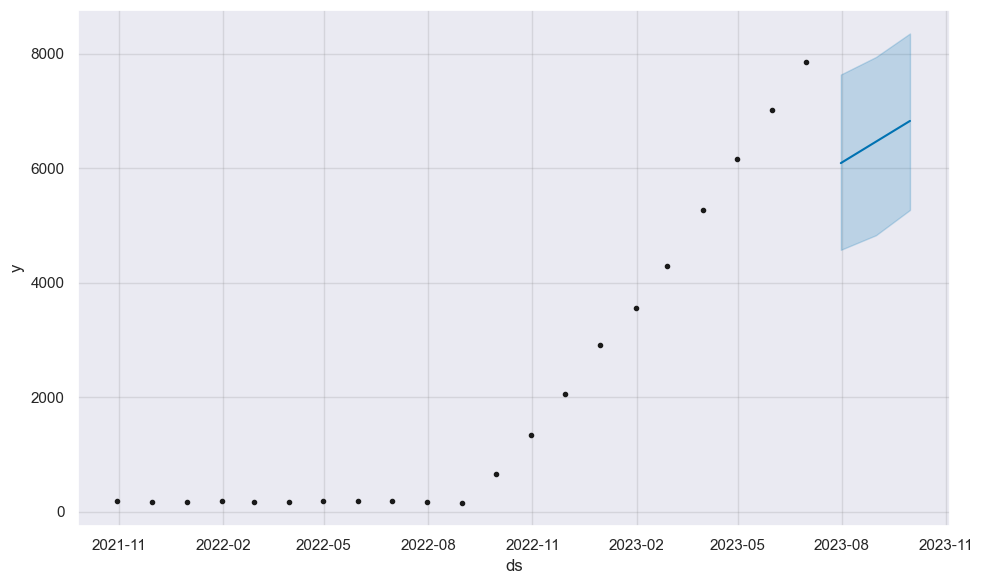

In [323]:
model.plot(pred);

F:\study\Hackatons\DashboardSber\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


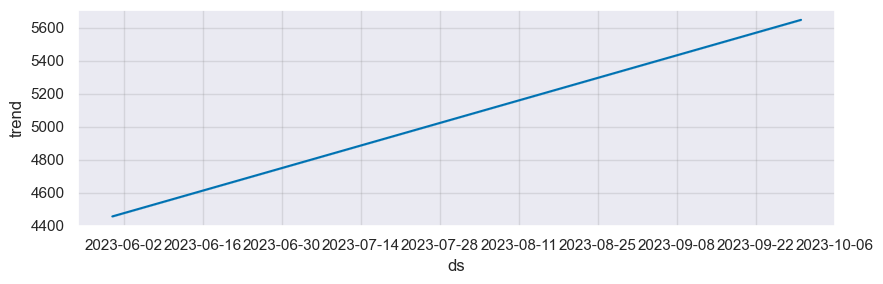

In [237]:
model.plot_components(pred);

In [ ]:
# Calculate root mean squared error.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1682, 'yhat']-transactions['y'])**2)) )